<h1>loading data</h1>

In [1]:
import os
import re

import pandas as pd
import numpy as np

from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_dir = '/Users/boyuliu/pyprojects/Joann/Joann-Thailand-Project/notebooks/datasets/new_dataset/'
raw_demand_3yrs = pd.read_csv(data_dir + 'raw_demand_3yrs.csv')
cases1 = pd.read_csv(data_dir + 'double_cases_boyu_incl.csv')
cases2 = pd.read_csv(data_dir + 'double_cases_boyu_excl.csv')
cases3 = pd.read_csv(data_dir + 'double_cases_joann_incl.csv')
cases4 = pd.read_csv(data_dir + 'double_cases_joann_excl.csv')

provinces = pd.read_csv(data_dir + 'provinces.csv')

merge_method = 'right'

In [6]:
provinces.head()

,id,name
0,62,Chiang Mai
1,63,Chiang Rai
2,64,Phetchaburi
3,65,Phetchabun
4,66,Loei


In [7]:
raw_demand_3yrs.head()

,province,total,week,year,industry,male,female,year_week
0,Phra Nakhon Si Ayutthaya,50,16,2017,Construction,35,15,2017-16
1,Bangkok,15,48,2017,Construction,15,0,2017-48
2,Saraburi,20,16,2017,Food and Beverage,12,8,2017-16
3,Bangkok,100,5,2017,Construction,60,40,2017-05
4,Bangkok,100,5,2017,Construction,60,40,2017-05


In [8]:
demand_data = raw_demand_3yrs.groupby(['province','year_week']).sum()['total'].reset_index().rename(columns={'total':'total_demand'})
demand_data

,province,year_week,total_demand
0,Amnat Charoen,2019-21,15
1,Amnat Charoen,2019-44,30
2,Amnat Charoen,2020-05,30
3,Ang Thong,2017-20,50
4,Ang Thong,2017-22,10
...,...,...,...
3759,Uttaradit,2019-28,30
3760,Uttaradit,2019-34,16
3761,Uttaradit,2020-09,3
3762,Yasothon,2018-43,10


<h1>combine demand data with wv data classification 1</h1>

In [9]:
def date_to_year_week(d):
    year_week = dt.strptime(d, '%Y-%m-%d').strftime('%Y-%W')
    yr, wk = year_week.split('-')
    return '%s-%02d' % (yr, (int(wk)+1))
    
cases_data = {
    'wv_cases1':cases1,
    'wv_cases2':cases2,
    'wv_cases3':cases3,
    'wv_cases4':cases4
}
wv_data_file = 'wv_cases1'
wv_data = cases_data[wv_data_file]
wv_data['year_week'] = wv_data['call_date'].apply(date_to_year_week)
print(wv_data.shape)
wv_data.sample(5)

(14339, 10)


,call_date,client_ethnicity_id,client_gender_id,client_nationality_id,client_status_id,country_id,province_id,supplier_id,abuse,year_week
7762,2020-07-13,9.0,1.0,2.0,3.0,8.0,70.0,1083.0,1.0,2020-29
11505,2018-01-01,NaN,2.0,1.0,NaN,8.0,119.0,NaN,0,2018-02
3703,2019-08-29,1.0,2.0,1.0,1.0,8.0,123.0,1083.0,NaN,2019-35
9690,2020-11-03,1.0,2.0,1.0,2.0,8.0,119.0,1083.0,NaN,2020-45
1319,2018-12-03,1.0,1.0,5.0,3.0,8.0,70.0,5685.0,0.0,2018-50


In [10]:
wv_data[pd.isnull(wv_data.province_id)].shape

(0, 10)

In [11]:
cols_lean = ['country_id','province_id', 'year_week', 'abuse']
wv_data = wv_data.loc[:, cols_lean]
wv_data.loc[pd.isnull(wv_data.abuse), 'abuse'] = 0
wv_data.loc[wv_data.abuse=='0.0', 'abuse'] = 0
wv_data.loc[wv_data.abuse=='0', 'abuse'] = 0
wv_data.loc[wv_data.abuse=='1.0', 'abuse'] = 1.
wv_data.loc[wv_data.abuse==False, 'abuse'] = 0
wv_data.loc[wv_data.abuse==True, 'abuse'] = 1
wv_data.loc[wv_data.abuse=='True', 'abuse'] = 1
wv_data.loc[wv_data.abuse=='False', 'abuse'] = 0

assert sum(wv_data.abuse.apply(type)==str)==0

total_trend = wv_data.groupby(['province_id', 'year_week']).count()['abuse'].reset_index()
total_trend.rename(columns={'abuse':'wv_count'}, inplace=True)
total_trend = total_trend.set_index(['province_id', 'year_week']).T.squeeze()

numerator = wv_data.groupby(['province_id', 'year_week']).sum()['abuse'].reset_index()
numerator = numerator.set_index(['province_id', 'year_week']).T.squeeze()

percent_abuse = numerator.divide(total_trend, fill_value=0)
percent_abuse = pd.DataFrame(percent_abuse).reset_index()

percent_abuse = percent_abuse.rename(columns={0: 'perc_abuse'})
percent_abuse_m = pd.merge(percent_abuse, total_trend, on=['province_id', 'year_week'])
percent_abuse_m = pd.merge(percent_abuse_m, provinces, how='outer', left_on='province_id', right_on='id', indicator=True)
percent_abuse_m._merge.value_counts()

both          2553
left_only      155
right_only      15
Name: _merge, dtype: int64

In [12]:
percent_abuse_m[percent_abuse_m._merge!='both'].province_id.unique()

array([  8.,  21.,  24.,  39.,  44.,  46.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61., 140.,  nan])

In [13]:
percent_abuse_m[percent_abuse_m._merge!='both'].id.unique()

array([ nan,  66.,  92.,  93., 100., 102., 103., 106., 107., 108., 110.,
       130., 132., 134., 136., 138.])

In [14]:
percent_abuse_m = pd.merge(percent_abuse, total_trend, on=['province_id', 'year_week'])
percent_abuse_m = pd.merge(percent_abuse_m, provinces, how='inner', left_on='province_id', right_on='id')
percent_abuse_m = percent_abuse_m.drop(['province_id','id'], axis=1).rename(columns={'name': 'province'})

percent_abuse_m.to_csv(data_dir + 'new_%s.csv' % wv_data_file, index=False)
percent_abuse_m.head()

,year_week,perc_abuse,wv_count,province
0,2018-03,0.0,1,Chiang Mai
1,2018-07,0.0,4,Chiang Mai
2,2018-08,0.0,2,Chiang Mai
3,2018-09,0.0,1,Chiang Mai
4,2018-12,0.0,1,Chiang Mai


## combine demand and wv abuse data

In [15]:
print(demand_data.shape, demand_data.year_week.max(), demand_data.year_week.min())
print(percent_abuse_m.shape, percent_abuse_m.year_week.max(), percent_abuse_m.year_week.min())

(3764, 3) 2020-09 2017-01
(2553, 4) 2020-50 2018-02


In [16]:
demand_provs = demand_data.province.unique()
abuse_provs = percent_abuse_m.province.unique()
overlap_provs = [p for p in demand_provs if p in abuse_provs]
print(len(overlap_provs))
abuse_only = [p for p in abuse_provs if p not in demand_provs]
abuse_only

58


['Mae Hong Son', 'Nakhon Phanom', 'Pattani', 'Yala']

In [17]:
# demand only
[p for p in demand_provs if p not in abuse_provs]

['Amnat Charoen',
 'Bueng Kan',
 'Loei',
 'Mukdahan',
 'Nan',
 'Nong Bua Lam Phu',
 'Phatthalung',
 'Phayao',
 'Phichit',
 'Roi Et',
 'Surin',
 'Ubon Ratchathani',
 'Uttaradit',
 'Yasothon']

In [18]:
', '.join(overlap_provs)

'Ang Thong, Bangkok, Buri Ram, Chachoengsao, Chainat, Chaiyaphum, Chanthaburi, Chiang Mai, Chiang Rai, Chonburi, Chumphon, Kalasin, Kamphaeng Phet, Kanchanaburi, Khon Kaen, Krabi, Lampang, Lamphun, Lopburi, Nakhon Nayok, Nakhon Pathom, Nakhon Ratchasima, Nakhon Sawan, Nakhon Si Thammarat, Narathiwat, Nong Khai, Nonthaburi, Pathum Thani, Phang Nga, Phetchabun, Phetchaburi, Phitsanulok, Phra Nakhon Si Ayutthaya, Phrae, Phuket, Prachin Buri, Prachuap Khiri Khan, Ranong, Ratchaburi, Rayong, Sa Kaeo, Sakon Nakhon, Samut Prakan, Samut Sakhon, Samut Songkhram, Saraburi, Satun, Si Saket, Sing Buri, Songkhla, Sukhothai, Suphanburi, Surat Thani, Tak, Trang, Trat, Udon Thani, Uthai Thani'

In [19]:
for p in abuse_only:
    total_wv = percent_abuse_m[percent_abuse_m.province==p].sum()['wv_count']
    print(p, total_wv)
print('Benchmark Bangkok wv count:', percent_abuse_m[percent_abuse_m.province=='Bangkok'].sum()['wv_count'])
print('Benchmark Nakhon Pathom wv count:', percent_abuse_m[percent_abuse_m.province=='Nakhon Pathom'].sum()['wv_count'])

Mae Hong Son 4
Nakhon Phanom 51
Pattani 39
Yala 6
Benchmark Bangkok wv count: 3296
Benchmark Nakhon Pathom wv count: 360


In [20]:
min_week = max(demand_data.year_week.min(), percent_abuse_m.year_week.min())
max_week = min(demand_data.year_week.max(), percent_abuse_m.year_week.max())

df = pd.merge(demand_data, percent_abuse_m, on=['province','year_week'], how='outer')
df['total_demand'].fillna(0, inplace=True)
df['perc_abuse'].fillna(0, inplace=True)
df['wv_count'].fillna(0, inplace=True)
df = df[df.province.isin(overlap_provs)]
df = df[(df['year_week']>=min_week) & (df['year_week']<=max_week)]
print('duplicates:', df[df.duplicated(['province','year_week'])].shape[0])
df

duplicates: 0


,province,year_week,total_demand,perc_abuse,wv_count
7,Ang Thong,2018-05,10.0,0.0,0.0
8,Ang Thong,2018-09,15.0,0.0,0.0
9,Ang Thong,2018-20,25.0,0.0,0.0
10,Ang Thong,2018-24,4.0,0.0,0.0
11,Ang Thong,2018-26,60.0,0.0,0.0
...,...,...,...,...,...
5021,Nong Khai,2018-11,0.0,0.0,1.0
5022,Nong Khai,2018-31,0.0,0.0,1.0
5023,Nong Khai,2019-32,0.0,0.0,1.0
5026,Ang Thong,2019-32,0.0,1.0,1.0


In [21]:
all_weeks = sorted(df.year_week.unique())
for i in range(len(all_weeks)-1):
    if int(all_weeks[i+1][-2:]) - int(all_weeks[i][-2:]) !=1:
        print(all_weeks[i+1])

2019-01
2020-01


In [22]:
# all_weeks = ['2018-{:02d}'.format(i) for i in range(45, 53)] + \
#             ['2019-{:02d}'.format(i) for i in range(1, 54)] + \
#             ['2020-{:02d}'.format(i) for i in range(1, 10)]

provinces_list = sorted(df.province.unique().tolist())

df_filled = df.copy()

for prov in provinces_list:
    loc_weeks = df[df.province==prov].year_week.tolist()
    missed_weeks = [i for i in all_weeks if i not in loc_weeks]
    missed_num = len(missed_weeks)
    data_to_add = pd.DataFrame(data={'province': [prov]*missed_num,
                                    'year_week': missed_weeks,
                                    'total_demand': [0]*missed_num,
                                    'perc_abuse': [0]*missed_num,
                                    'wv_count': [0]*missed_num})
    df_filled = df_filled.append(data_to_add, sort=False)
    
df_filled = df_filled.sort_values(['province','year_week'])
print(df_filled.shape)

(6554, 5)


In [23]:
for loc in provinces_list:
    loc_weeks = df_filled[df_filled.province==loc].year_week.tolist()
    missed_weeks = [i for i in all_weeks if i not in loc_weeks]
    missed_num = len(missed_weeks)
    if missed_num > 0:
        print(loc, missed_num)
        raise
        
# df_filled.to_csv(
#     data_dir + 'regression_data_%s_20210301.csv' % wv_data_file, 
#     index=False)

<h1>go over other 3 datasets and do the same</h1>

In [35]:


# for wv_data_file in cases_data.keys():
#     # skip first file and get the rest
#     if wv_data_file == 'wv_cases1': continue
#     print(wv_data_file)
#     wv_data = cases_data[wv_data_file]
#     # prep wv data
#     wv_data['year_week'] = wv_data['call_date'].apply(date_to_year_week)
#     print(wv_data.shape)
#     cols_lean = ['province_id', 'year_week', 'abuse']
#     wv_data = wv_data.loc[:, cols_lean]
#     wv_data.loc[pd.isnull(wv_data.abuse), 'abuse'] = 0
#     wv_data.loc[wv_data.abuse=='0.0', 'abuse'] = 0
#     wv_data.loc[wv_data.abuse=='1.0', 'abuse'] = 1
#     wv_data.loc[wv_data.abuse=='0', 'abuse'] = 0
#     wv_data.loc[wv_data.abuse=='1', 'abuse'] = 1
#     wv_data.loc[wv_data.abuse==False, 'abuse'] = 0
#     wv_data.loc[wv_data.abuse==True, 'abuse'] = 1
#     wv_data.loc[wv_data.abuse=='True', 'abuse'] = 1
#     wv_data.loc[wv_data.abuse=='False', 'abuse'] = 0
    
#     # calculate percentages
#     total_trend = wv_data.groupby(['province_id', 'year_week']).count()['abuse'].reset_index()
#     total_trend.rename(columns={'abuse':'wv_count'}, inplace=True)
#     total_trend = total_trend.set_index(['province_id', 'year_week']).T.squeeze()
    
# #     import pdb; pdb.set_trace()
#     numerator = wv_data.groupby(['province_id', 'year_week']).sum()['abuse'].reset_index()
#     numerator = numerator.set_index(['province_id', 'year_week']).T.squeeze()

#     percent_abuse = numerator.divide(total_trend, fill_value=0)
#     percent_abuse = pd.DataFrame(percent_abuse).reset_index()
#     percent_abuse = percent_abuse.rename(columns={0: 'perc_abuse'})
#     # merge with province and save
#     percent_abuse_m = pd.merge(percent_abuse, total_trend, on=['province_id', 'year_week'])
#     percent_abuse_m = pd.merge(percent_abuse_m, provinces, how='inner', left_on='province_id', right_on='id')
#     percent_abuse_m = percent_abuse_m.drop(['province_id','id'], axis=1).rename(columns={'name': 'province'})

#     percent_abuse_m.to_csv(data_dir + 'new_%s.csv' % wv_data_file, index=False)
#     # merge demand and abuse
#     df = pd.merge(demand_data, percent_abuse_m, on=['province','year_week'], how='outer')
#     df['total_demand'].fillna(0, inplace=True)
#     df['perc_abuse'].fillna(0, inplace=True)
#     df['wv_count'].fillna(0, inplace=True)
#     df = df[df.province.isin(overlap_provs)]
#     df = df[(df['year_week']>=min_week) & (df['year_week']<=max_week)]
#     print('duplicates:', df[df.duplicated(['province','year_week'])].shape[0])
    
#     # add rows to fill in missing weeks
#     df_filled = df.copy()

#     for prov in provinces_list:
#         loc_weeks = df[df.province==prov].year_week.tolist()
#         missed_weeks = [i for i in all_weeks if i not in loc_weeks]
#         missed_num = len(missed_weeks)
#         data_to_add = pd.DataFrame(data={'province': [prov]*missed_num,
#                                         'year_week': missed_weeks,
#                                         'total_demand': [0]*missed_num,
#                                         'perc_abuse': [0]*missed_num,
#                                         'wv_count': [0]*missed_num})
#         df_filled = df_filled.append(data_to_add, sort=False)

#     df_filled = df_filled.sort_values(['province','year_week'])
#     print(df_filled.shape)

#     for loc in provinces_list:
#         loc_weeks = df_filled[df_filled.province==loc].year_week.tolist()
#         missed_weeks = [i for i in all_weeks if i not in loc_weeks]
#         missed_num = len(missed_weeks)
#         if missed_num > 0:
#             print(loc, missed_num)
#             raise

#     df_filled.to_csv(
#         data_dir + 'regression_data_%s_20210301.csv' % wv_data_file, 
#         index=False)

wv_cases2
(14339, 10)
duplicates: 0
(6554, 5)
wv_cases3
(14339, 10)
duplicates: 0
(6554, 5)
wv_cases4
(14339, 10)
duplicates: 0
(6554, 5)


In [36]:
# df_filled = pd.read_csv(data_dir + 'regression_data_wv_cases1.csv')
print(df_filled.shape)
print(df_filled.year_week.max(), df_filled.year_week.min())

(6554, 5)
2020-09 2018-02


In [37]:
df_filled.head(10)

,province,year_week,total_demand,perc_abuse,wv_count
0,Ang Thong,2018-02,0.0,0.0,0.0
1,Ang Thong,2018-03,0.0,0.0,0.0
2,Ang Thong,2018-04,0.0,0.0,0.0
7,Ang Thong,2018-05,10.0,0.0,0.0
3,Ang Thong,2018-06,0.0,0.0,0.0
4,Ang Thong,2018-07,0.0,0.0,0.0
5,Ang Thong,2018-08,0.0,0.0,0.0
8,Ang Thong,2018-09,15.0,0.0,0.0
6,Ang Thong,2018-10,0.0,0.0,0.0
7,Ang Thong,2018-11,0.0,0.0,0.0


In [38]:
df_filled.tail()

,province,year_week,total_demand,perc_abuse,wv_count
105,Uthai Thani,2020-05,0.0,0.0,0.0
106,Uthai Thani,2020-06,0.0,0.0,0.0
107,Uthai Thani,2020-07,0.0,0.0,0.0
108,Uthai Thani,2020-08,0.0,0.0,0.0
109,Uthai Thani,2020-09,0.0,0.0,0.0


In [20]:
os.listdir('/Users/boyuliu/Dropbox/Boyu-Joann/Data/exchange_rate/')

['.DS_Store',
 'ER31122016-31122017.csv',
 'ER20112019-16112020.csv',
 'Malaysia',
 'weekly_xy_detrend.csv',
 'ER31122017-31122018.csv',
 'China',
 'ER31122018-19122019.csv',
 'weekly_exchange_rate.csv',
 'weekly_exchange_rate_detrend.csv',
 'detrend_weekly_data.csv']

<h1>add IV</h1>

In [21]:
# folder = '/Users/boyuliu/Dropbox/Boyu-Joann/Data/exchange_rate/China/'
# iv = pd.read_csv(folder + 'weekly_CNY_exchange_rate.csv')
folder = '/Users/boyuliu/Dropbox/Boyu-Joann/Data/exchange_rate/'
iv = pd.read_csv(folder + 'weekly_exchange_rate.csv')
print(iv.year_week.max(), iv.year_week.min(), iv.shape)
iv.head()
# weekly = pd.merge(weekly, iv[['year_week','ex_rate']], on='year_week', how='left')
# weekly.shape

2020-47 2017-01 (203, 3)


,year_week,ex_rate,fake_date
0,2017-01,35.965467,2017-01-01
1,2017-02,35.725580,2017-01-08
2,2017-03,35.546960,2017-01-15
3,2017-04,35.431980,2017-01-22
4,2017-05,35.332080,2017-01-29


In [23]:
iv.year_week.min(), iv.year_week.max()

('2017-01', '2020-47')

In [22]:
iv['month'] = iv['fake_date'].apply(lambda x: x[:-3])
iv['quarter'] = iv['fake_date'].apply(lambda x: x[:5] + str((int(x[5:7])-1)//3 + 1))
iv['ex_rate_diff'] = iv['ex_rate'] - iv['ex_rate'].shift(1)
# shift IV by up to 2 months
for offset in range(1, 9):
    iv['ex_rate_diff_plus_%s' % offset] = iv['ex_rate_diff'].shift(offset)
# shift IV the other way by up to 2 months    
for offset in range(1, 9):
    iv['ex_rate_diff_minus_%s' % offset] = iv['ex_rate_diff'].shift(-offset)
#     iv['ex_rate_diff_%s' % offset] = iv['ex_rate'] - iv['ex_rate'].shift(-offset)    
iv.head()

,year_week,ex_rate,fake_date,month,quarter,ex_rate_diff,ex_rate_diff_plus_1,ex_rate_diff_plus_2,ex_rate_diff_plus_3,ex_rate_diff_plus_4,...,ex_rate_diff_plus_7,ex_rate_diff_plus_8,ex_rate_diff_minus_1,ex_rate_diff_minus_2,ex_rate_diff_minus_3,ex_rate_diff_minus_4,ex_rate_diff_minus_5,ex_rate_diff_minus_6,ex_rate_diff_minus_7,ex_rate_diff_minus_8
0,2017-01,35.965467,2017-01-01,2017-01,2017-1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.239887,-0.17862,-0.11498,-0.09990,-0.12702,-0.02011,-0.00893,-0.04588
1,2017-02,35.725580,2017-01-08,2017-01,2017-1,-0.239887,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.178620,-0.11498,-0.09990,-0.12702,-0.02011,-0.00893,-0.04588,0.22930
2,2017-03,35.546960,2017-01-15,2017-01,2017-1,-0.178620,-0.239887,NaN,NaN,NaN,...,NaN,NaN,-0.114980,-0.09990,-0.12702,-0.02011,-0.00893,-0.04588,0.22930,-0.00516
3,2017-04,35.431980,2017-01-22,2017-01,2017-1,-0.114980,-0.178620,-0.239887,NaN,NaN,...,NaN,NaN,-0.099900,-0.12702,-0.02011,-0.00893,-0.04588,0.22930,-0.00516,-0.49622
4,2017-05,35.332080,2017-01-29,2017-01,2017-1,-0.099900,-0.114980,-0.178620,-0.239887,NaN,...,NaN,NaN,-0.127020,-0.02011,-0.00893,-0.04588,0.22930,-0.00516,-0.49622,-0.22884


In [36]:
for wv_data_file in cases_data.keys():
    print(wv_data_file)
    df = pd.read_csv(
        data_dir + 'regression_data_%s_20210301.csv' % wv_data_file)
#     dup_cols = [col for col in df.columns if col[-1]=='x' or col[-1]=='y']
#     df = df.drop(dup_cols, axis=1)
    print(df.shape)
    df = pd.merge(df.iloc[:, :5], iv, on='year_week', how='left')
    print(df.shape)
#     dup_cols = [col for col in df.columns if col[-1]=='x' or col[-1]=='y']
#     df = df.drop(dup_cols, axis=1)
    df.to_csv(
        data_dir + 'regression_data_%s_USD_20210311.csv' % wv_data_file, 
        index=False)

wv_cases1
(6554, 43)
(6554, 26)
wv_cases2
(6554, 42)
(6554, 26)
wv_cases3
(6554, 42)
(6554, 26)
wv_cases4
(6554, 42)
(6554, 26)


In [37]:
# df = pd.read_csv(
#         data_dir + 'regression_data_%s_20210301.csv' % wv_data_file)
df.head()

,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff,...,ex_rate_diff_plus_7,ex_rate_diff_plus_8,ex_rate_diff_minus_1,ex_rate_diff_minus_2,ex_rate_diff_minus_3,ex_rate_diff_minus_4,ex_rate_diff_minus_5,ex_rate_diff_minus_6,ex_rate_diff_minus_7,ex_rate_diff_minus_8
0,Ang Thong,2018-02,0.0,0.0,0.0,32.29036,2018-01-08,2018-01,2018-1,-0.188473,...,-0.264220,-0.111780,-0.20148,-0.27140,-0.27778,0.24992,-0.19034,0.03324,-0.06972,-0.03246
1,Ang Thong,2018-03,0.0,0.0,0.0,32.08888,2018-01-15,2018-01,2018-1,-0.201480,...,-0.126420,-0.264220,-0.27140,-0.27778,0.24992,-0.19034,0.03324,-0.06972,-0.03246,-0.12658
2,Ang Thong,2018-04,0.0,0.0,0.0,31.81748,2018-01-22,2018-01,2018-1,-0.271400,...,0.005105,-0.126420,-0.27778,0.24992,-0.19034,0.03324,-0.06972,-0.03246,-0.12658,-0.00444
3,Ang Thong,2018-05,10.0,0.0,0.0,31.53970,2018-01-29,2018-01,2018-1,-0.277780,...,-0.076400,0.005105,0.24992,-0.19034,0.03324,-0.06972,-0.03246,-0.12658,-0.00444,-0.02158
4,Ang Thong,2018-06,0.0,0.0,0.0,31.78962,2018-02-05,2018-02,2018-1,0.249920,...,0.148315,-0.076400,-0.19034,0.03324,-0.06972,-0.03246,-0.12658,-0.00444,-0.02158,0.00076


In [38]:
df.columns

Index(['province', 'year_week', 'total_demand', 'perc_abuse', 'wv_count',
       'ex_rate', 'fake_date', 'month', 'quarter', 'ex_rate_diff',
       'ex_rate_diff_plus_1', 'ex_rate_diff_plus_2', 'ex_rate_diff_plus_3',
       'ex_rate_diff_plus_4', 'ex_rate_diff_plus_5', 'ex_rate_diff_plus_6',
       'ex_rate_diff_plus_7', 'ex_rate_diff_plus_8', 'ex_rate_diff_minus_1',
       'ex_rate_diff_minus_2', 'ex_rate_diff_minus_3', 'ex_rate_diff_minus_4',
       'ex_rate_diff_minus_5', 'ex_rate_diff_minus_6', 'ex_rate_diff_minus_7',
       'ex_rate_diff_minus_8'],
      dtype='object')

In [39]:
print(df.year_week.max(), df.year_week.min())
print(df.shape)

2020-09 2018-02
(6554, 26)


## shift demand as well

In [40]:
df.iloc[:10, 9:19]

,ex_rate_diff,ex_rate_diff_plus_1,ex_rate_diff_plus_2,ex_rate_diff_plus_3,ex_rate_diff_plus_4,ex_rate_diff_plus_5,ex_rate_diff_plus_6,ex_rate_diff_plus_7,ex_rate_diff_plus_8,ex_rate_diff_minus_1
0,-0.188473,-0.424407,0.033500,0.148315,-0.076400,0.005105,-0.126420,-0.264220,-0.111780,-0.20148
1,-0.201480,-0.188473,-0.424407,0.033500,0.148315,-0.076400,0.005105,-0.126420,-0.264220,-0.27140
2,-0.271400,-0.201480,-0.188473,-0.424407,0.033500,0.148315,-0.076400,0.005105,-0.126420,-0.27778
3,-0.277780,-0.271400,-0.201480,-0.188473,-0.424407,0.033500,0.148315,-0.076400,0.005105,0.24992
4,0.249920,-0.277780,-0.271400,-0.201480,-0.188473,-0.424407,0.033500,0.148315,-0.076400,-0.19034
5,-0.190340,0.249920,-0.277780,-0.271400,-0.201480,-0.188473,-0.424407,0.033500,0.148315,0.03324
6,0.033240,-0.190340,0.249920,-0.277780,-0.271400,-0.201480,-0.188473,-0.424407,0.033500,-0.06972
7,-0.069720,0.033240,-0.190340,0.249920,-0.277780,-0.271400,-0.201480,-0.188473,-0.424407,-0.03246
8,-0.032460,-0.069720,0.033240,-0.190340,0.249920,-0.277780,-0.271400,-0.201480,-0.188473,-0.12658
9,-0.126580,-0.032460,-0.069720,0.033240,-0.190340,0.249920,-0.277780,-0.271400,-0.201480,-0.00444


In [41]:
for wv_data_file in cases_data.keys():
    print(wv_data_file)
    df = pd.read_csv(
        data_dir + 'regression_data_%s_USD_20210311.csv' % wv_data_file)
#     dup_cols = [col for col in df.columns if col[-1]=='x' or col[-1]=='y']
#     df = df.drop(dup_cols, axis=1)
    print(df.shape)
    
    # create placeholder
    for offset in range(1, 9):
        df['total_demand_plus_%s' % offset] = None
    # shift IV the other way by up to 2 months    
    for offset in range(1, 9):
        df['total_demand_minus_%s' % offset] = None
        
    for prov in df.province.unique():
        prov_row_idx = df[df.province==prov].index 

        for offset in range(1, 9):
            df.loc[prov_row_idx, 'total_demand_plus_%s' % offset] = df.loc[prov_row_idx, 'total_demand'].shift(offset)
        # shift IV the other way by up to 2 months    
        for offset in range(1, 9):
            df.loc[prov_row_idx, 'total_demand_minus_%s' % offset] = df.loc[prov_row_idx, 'total_demand'].shift(-offset)

    print(df.shape)
#     break
#     dup_cols = [col for col in df.columns if col[-1]=='x' or col[-1]=='y']
#     df = df.drop(dup_cols, axis=1)
    df.to_csv(
        data_dir + 'regression_data_%s_USD_20210311.csv' % wv_data_file, 
        index=False)

wv_cases1
(6554, 26)
(6554, 42)
wv_cases2
(6554, 26)
(6554, 42)
wv_cases3
(6554, 26)
(6554, 42)
wv_cases4
(6554, 26)
(6554, 42)


In [29]:
df.loc[:10, [c for c in df.columns if c.startswith('total_demand')]]

,total_demand,total_demand_plus_1,total_demand_plus_2,total_demand_plus_3,total_demand_plus_4,total_demand_plus_5,total_demand_plus_6,total_demand_plus_7,total_demand_plus_8,total_demand_minus_1,total_demand_minus_2,total_demand_minus_3,total_demand_minus_4,total_demand_minus_5,total_demand_minus_6,total_demand_minus_7,total_demand_minus_8
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,10,0,0,0,15,0
1,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10,0,0,0,15,0,0
2,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,10,0,0,0,15,0,0,0
3,10.0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,15,0,0,0,0
4,0.0,10,0,0,0,NaN,NaN,NaN,NaN,0,0,15,0,0,0,0,0
5,0.0,0,10,0,0,0,NaN,NaN,NaN,0,15,0,0,0,0,0,0
6,0.0,0,0,10,0,0,0,NaN,NaN,15,0,0,0,0,0,0,0
7,15.0,0,0,0,10,0,0,0,NaN,0,0,0,0,0,0,0,0
8,0.0,15,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0
9,0.0,0,15,0,0,0,10,0,0,0,0,0,0,0,0,0,0


In [30]:
data_dir + 'regression_data_%s_USD_20210311.csv' % wv_data_file

'/Users/boyuliu/pyprojects/Joann/Joann-Thailand-Project/notebooks/datasets/new_dataset/regression_data_wv_cases4_USD_20210311.csv'

In [28]:
testfile = '/Users/boyuliu/pyprojects/Joann/Joann-Thailand-Project/notebooks/datasets/new_dataset/regression_data_wv_cases4_USD_20210311.csv'
testfile = pd.read_csv(testfile)
testfile.shape

(6554, 42)

## remove provinces with no wv data

In [47]:
wv_data_file

'wv_cases4'

In [48]:
wv_data_file = 'wv_cases1'
print(wv_data_file)
df = pd.read_csv(data_dir + 'regression_data_%s_20210301.csv' % wv_data_file)
print(df.shape)
df.head()

wv_cases1
(6554, 42)


,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff,...,total_demand_plus_7,total_demand_plus_8,total_demand_minus_1,total_demand_minus_2,total_demand_minus_3,total_demand_minus_4,total_demand_minus_5,total_demand_minus_6,total_demand_minus_7,total_demand_minus_8
0,Ang Thong,2018-02,0.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,-0.032813,...,NaN,NaN,0.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0
1,Ang Thong,2018-03,0.0,0.0,0.0,5.02540,2018-01-15,2018-01,2018-1,0.019380,...,NaN,NaN,0.0,10.0,0.0,0.0,0.0,15.0,0.0,0.0
2,Ang Thong,2018-04,0.0,0.0,0.0,5.03024,2018-01-22,2018-01,2018-1,0.004840,...,NaN,NaN,10.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0
3,Ang Thong,2018-05,10.0,0.0,0.0,5.03048,2018-01-29,2018-01,2018-1,0.000240,...,NaN,NaN,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0
4,Ang Thong,2018-06,0.0,0.0,0.0,5.08050,2018-02-05,2018-02,2018-1,0.050020,...,NaN,NaN,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0


In [49]:
by_prov_counts = df.groupby('province').sum()['wv_count']
by_prov_counts.shape

(58,)

In [50]:
by_week_counts = df.groupby('year_week').sum()['wv_count']
print(by_week_counts.shape)
by_week_counts

(113,)


year_week
2018-02     49.0
2018-03    122.0
2018-04     63.0
2018-05     59.0
2018-06     77.0
           ...  
2020-05    105.0
2020-06     93.0
2020-07     78.0
2020-08     78.0
2020-09     80.0
Name: wv_count, Length: 113, dtype: float64

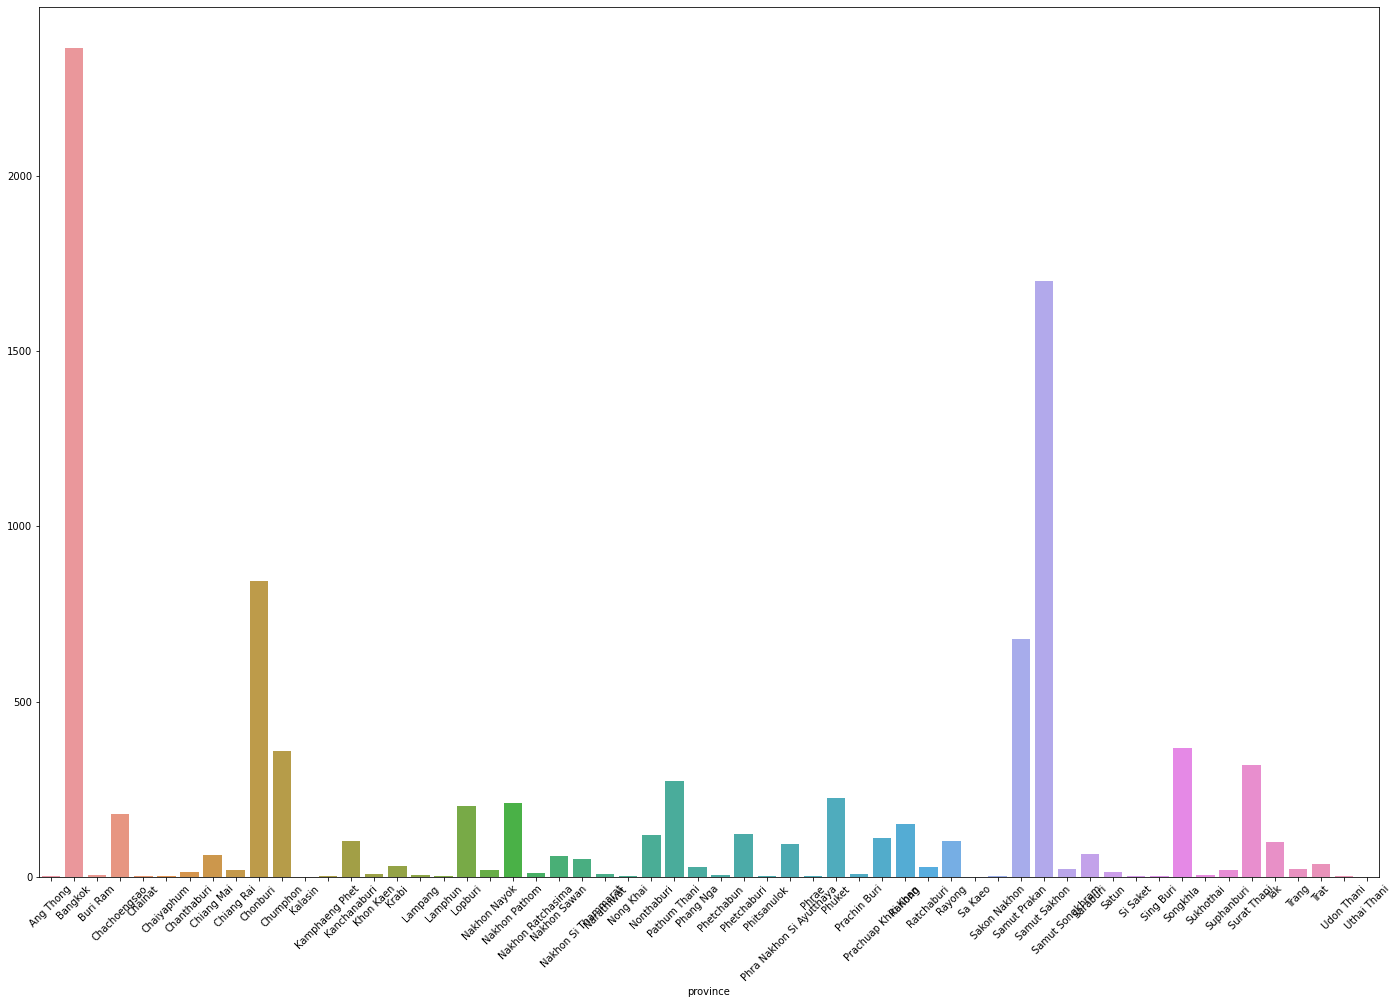

In [51]:
a4_dims = (24, 16)
fig, ax = plt.subplots(figsize=a4_dims)
histp = sns.barplot(x=by_prov_counts.index, y=by_prov_counts.tolist())
for item in histp.get_xticklabels():
    item.set_rotation(45)
plt.show()

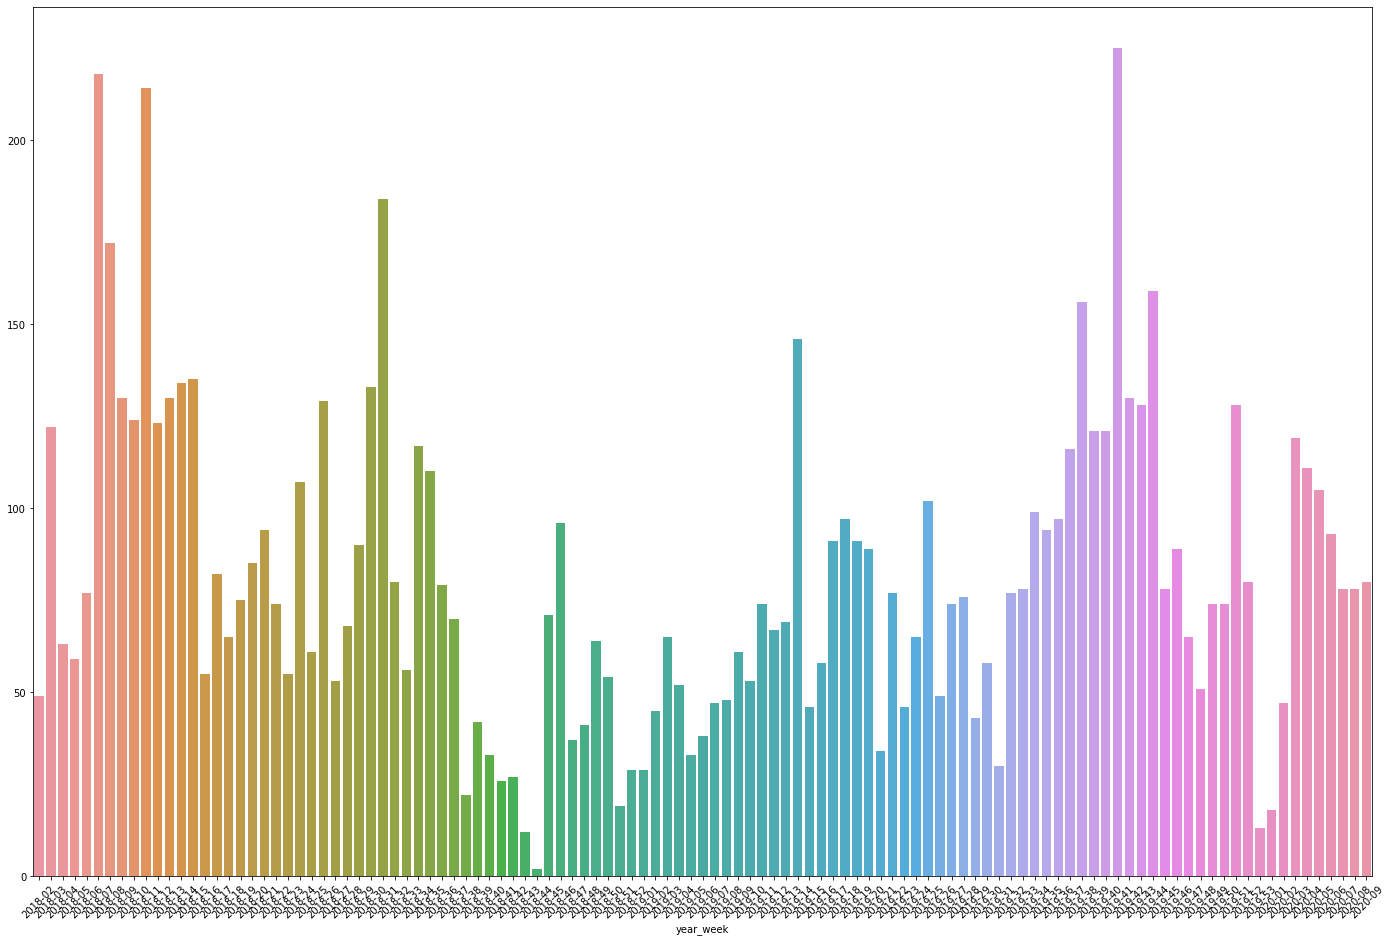

In [52]:
a4_dims = (24, 16)
fig, ax = plt.subplots(figsize=a4_dims)
histp = sns.barplot(x=by_week_counts.index, y=by_week_counts.tolist())
for item in histp.get_xticklabels():
    item.set_rotation(45)
plt.show()

there are 35 provinces with more than 10 wv counts


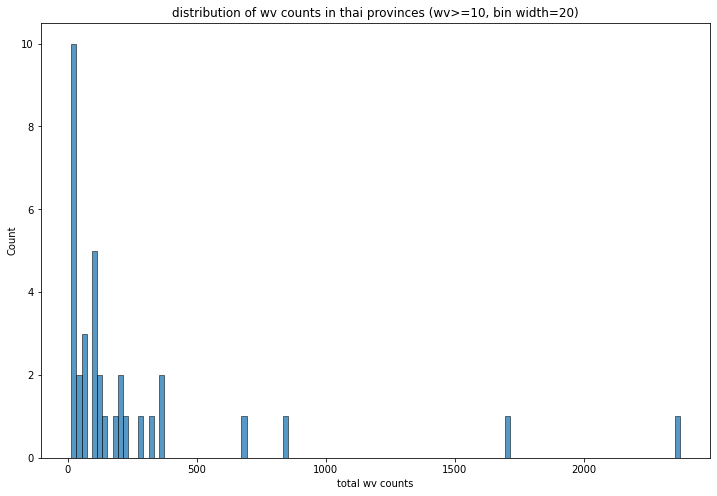

In [53]:
print("there are %s provinces with more than 10 wv counts" % len([n for n in by_prov_counts.tolist() if n>10]))

a4_dims = (12, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot([n for n in by_prov_counts.tolist() if n>10], binwidth=20)
plt.xlabel('total wv counts')
plt.title('distribution of wv counts in thai provinces (wv>=10, bin width=20)')
plt.show()

58


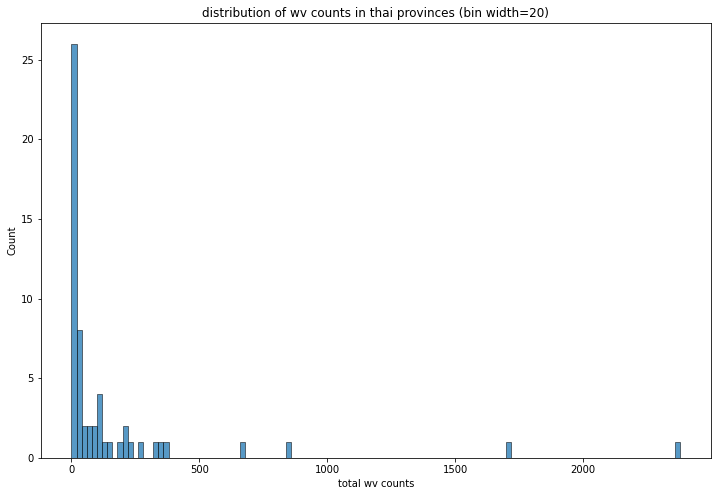

In [25]:
print(len(by_prov_counts.tolist()))

a4_dims = (12, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(by_prov_counts.tolist(), binwidth=20)
plt.xlabel('total wv counts')
plt.title('distribution of wv counts in thai provinces (bin width=20)')
plt.show()

In [54]:
', '.join([str(int(i)) for i in by_prov_counts.tolist()])

'1, 2363, 4, 180, 1, 3, 14, 63, 20, 843, 358, 0, 1, 102, 9, 30, 5, 2, 201, 20, 210, 10, 59, 51, 8, 3, 118, 274, 28, 6, 121, 2, 93, 2, 224, 9, 112, 152, 27, 102, 0, 3, 677, 1700, 21, 65, 13, 1, 2, 368, 5, 18, 320, 99, 22, 36, 1, 0'

In [55]:
df.province.unique()

array(['Ang Thong', 'Bangkok', 'Buri Ram', 'Chachoengsao', 'Chainat',
       'Chaiyaphum', 'Chanthaburi', 'Chiang Mai', 'Chiang Rai',
       'Chonburi', 'Chumphon', 'Kalasin', 'Kamphaeng Phet',
       'Kanchanaburi', 'Khon Kaen', 'Krabi', 'Lampang', 'Lamphun',
       'Lopburi', 'Nakhon Nayok', 'Nakhon Pathom', 'Nakhon Ratchasima',
       'Nakhon Sawan', 'Nakhon Si Thammarat', 'Narathiwat', 'Nong Khai',
       'Nonthaburi', 'Pathum Thani', 'Phang Nga', 'Phetchabun',
       'Phetchaburi', 'Phitsanulok', 'Phra Nakhon Si Ayutthaya', 'Phrae',
       'Phuket', 'Prachin Buri', 'Prachuap Khiri Khan', 'Ranong',
       'Ratchaburi', 'Rayong', 'Sa Kaeo', 'Sakon Nakhon', 'Samut Prakan',
       'Samut Sakhon', 'Samut Songkhram', 'Saraburi', 'Satun', 'Si Saket',
       'Sing Buri', 'Songkhla', 'Sukhothai', 'Suphanburi', 'Surat Thani',
       'Tak', 'Trang', 'Trat', 'Udon Thani', 'Uthai Thani'], dtype=object)

In [56]:
by_prov_count_lg = df[df.year_week>='2019'].groupby('province').sum()['wv_count']

In [57]:
by_prov_counts[by_prov_counts>50]

province
Bangkok                     2363.0
Chachoengsao                 180.0
Chiang Mai                    63.0
Chonburi                     843.0
Chumphon                     358.0
Kanchanaburi                 102.0
Lopburi                      201.0
Nakhon Pathom                210.0
Nakhon Sawan                  59.0
Nakhon Si Thammarat           51.0
Nonthaburi                   118.0
Pathum Thani                 274.0
Phetchaburi                  121.0
Phra Nakhon Si Ayutthaya      93.0
Phuket                       224.0
Prachuap Khiri Khan          112.0
Ranong                       152.0
Rayong                       102.0
Samut Prakan                 677.0
Samut Sakhon                1700.0
Saraburi                      65.0
Songkhla                     368.0
Surat Thani                  320.0
Tak                           99.0
Name: wv_count, dtype: float64

In [58]:
large_provinces = by_prov_counts[by_prov_counts>50].index.tolist()
large_provinces

['Bangkok',
 'Chachoengsao',
 'Chiang Mai',
 'Chonburi',
 'Chumphon',
 'Kanchanaburi',
 'Lopburi',
 'Nakhon Pathom',
 'Nakhon Sawan',
 'Nakhon Si Thammarat',
 'Nonthaburi',
 'Pathum Thani',
 'Phetchaburi',
 'Phra Nakhon Si Ayutthaya',
 'Phuket',
 'Prachuap Khiri Khan',
 'Ranong',
 'Rayong',
 'Samut Prakan',
 'Samut Sakhon',
 'Saraburi',
 'Songkhla',
 'Surat Thani',
 'Tak']

In [59]:
print(wv_data_file)
df = pd.read_csv(data_dir + 'regression_data_%s_20210301.csv' % wv_data_file)
print(df.shape)
df = df[df.province.isin(large_provinces)]
print(df.shape)
df.head()

wv_cases1
(6554, 42)
(2712, 42)


,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff,...,total_demand_plus_7,total_demand_plus_8,total_demand_minus_1,total_demand_minus_2,total_demand_minus_3,total_demand_minus_4,total_demand_minus_5,total_demand_minus_6,total_demand_minus_7,total_demand_minus_8
113,Bangkok,2018-02,620.0,0.181818,11.0,5.00602,2018-01-08,2018-01,2018-1,-0.032813,...,NaN,NaN,422.0,589.0,614.0,850.0,1109.0,261.0,510.0,643.0
114,Bangkok,2018-03,422.0,0.062500,32.0,5.02540,2018-01-15,2018-01,2018-1,0.019380,...,NaN,NaN,589.0,614.0,850.0,1109.0,261.0,510.0,643.0,946.0
115,Bangkok,2018-04,589.0,0.000000,13.0,5.03024,2018-01-22,2018-01,2018-1,0.004840,...,NaN,NaN,614.0,850.0,1109.0,261.0,510.0,643.0,946.0,810.0
116,Bangkok,2018-05,614.0,0.000000,10.0,5.03048,2018-01-29,2018-01,2018-1,0.000240,...,NaN,NaN,850.0,1109.0,261.0,510.0,643.0,946.0,810.0,1163.0
117,Bangkok,2018-06,850.0,0.062500,32.0,5.08050,2018-02-05,2018-02,2018-1,0.050020,...,NaN,NaN,1109.0,261.0,510.0,643.0,946.0,810.0,1163.0,457.0


In [60]:
df.to_csv(data_dir + 'regression_data_large_p_%s_20210301.csv' % wv_data_file, index=False)
# data_dir + 'regression_data_%s_20210301.csv' % wv_data_file

<h1>check WV industry availability</h1>

In [2]:
suppliers = pd.read_csv(data_dir+'suppliers.csv')
suppliers.head()

,Unnamed: 0,id,name,created,tier_id,address,zipcode,gps,vessel_number,fishing_gear_liscense_number,...,province_id,vessel_type_id,total_num_men_workers,total_num_women_workers,subindustry_id,golden_dreams_employer_id,description,website,lat,lng
0,0,1,89 Subcharoen,2020-01-16,NaN,-,-,-,-,NaN,...,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,49.284989,-123.110797
1,1,2,A. Anon,2020-01-16,NaN,-,-,-,-,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.284989,-123.110797
2,2,3,A. Arunsamut 1,2020-01-16,NaN,-,-,-,-,NaN,...,NaN,129.0,NaN,NaN,NaN,NaN,NaN,NaN,49.284989,-123.110797
3,3,4,A. Arunsamut 6,2020-01-16,NaN,-,-,-,-,NaN,...,NaN,129.0,NaN,NaN,NaN,NaN,NaN,NaN,49.284989,-123.110797
4,4,5,A. Arunsamut 7,2020-01-16,NaN,-,-,-,-,NaN,...,NaN,129.0,NaN,NaN,NaN,NaN,NaN,NaN,49.284989,-123.110797


In [24]:
wv_data = cases1
wv_data_w_industry = pd.merge(wv_data, suppliers[['id', 'industry_id']], left_on='supplier_id', right_on='id', how='left')
wv_data_w_industry.head()

,call_date,client_ethnicity_id,client_gender_id,client_nationality_id,client_status_id,country_id,province_id,supplier_id,abuse,year_week,id,industry_id
0,2018-11-17,1.0,1.0,5.0,3.0,8.0,70.0,5685.0,NaN,2018-47,5685.0,11.0
1,2018-11-18,1.0,2.0,5.0,3.0,8.0,119.0,391.0,0.0,2018-47,391.0,16.0
2,2018-11-17,NaN,1.0,5.0,3.0,8.0,105.0,1083.0,1.0,2018-47,1083.0,NaN
3,2018-11-19,1.0,1.0,5.0,3.0,8.0,114.0,NaN,NaN,2018-48,NaN,NaN
4,2018-11-19,1.0,1.0,5.0,11.0,8.0,77.0,5685.0,NaN,2018-48,5685.0,11.0


In [29]:
no_industry = sum(pd.isnull(wv_data_w_industry.industry_id))
total_count = wv_data_w_industry.shape[0]
print(no_industry, total_count, 1- no_industry/total_count, no_industry/total_count)

9837 14339 0.3139688960178534 0.6860311039821466


In [21]:
wv_data_w_industry['year'] = wv_data_w_industry['created'].apply(lambda x: x.split('-')[0])
# wv_data_w_industry['year'].hist()
# plt.show()

In [19]:
sum(pd.isnull(wv_data_w_industry.province_id))

0

In [24]:
sum(pd.isnull(wv_data_w_industry[wv_data_w_industry.year=='2019'].industry_id)), wv_data_w_industry[wv_data_w_industry.year=='2019'].shape[0]

(2446, 4236)